# Training Loop with Knowledge Distillation
## Reasoning Distillation Project

This notebook implements training with **token-level knowledge distillation**:

```
Dataset → Teacher Model → Soft Logits (probabilities)
       ↘                ↗
         Student Model
         
Loss = α·CE(student, labels) + β·KL(student||teacher)
```

### Contents:
1. Load Teacher Model (FLAN-T5-XL)
2. Load Student Model (FLAN-T5-Small/Base)
3. Configure Knowledge Distillation
4. Training Loop with Teacher Guidance
5. Evaluation and Checkpointing
6. Training History Visualization

In [ ]:
# Setup
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Imports
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import time
import zipfile

from src.data.data_loader import TeacherDataLoader
from src.data.preprocessor import ReasoningPreprocessor, PreprocessConfig
from src.data.dataset import ESNLIDataset, create_dataloaders

from src.models.student import StudentModel, StudentConfig, create_student_model
from src.models.teacher import FlanT5Teacher, TeacherConfig  # Neural teacher model

from src.training.distillation import (
    DistillationConfig,
    TokenLevelDistillation,  # Token-level with teacher
    DistillationLoss,
    compare_distillation_strategies
)

from src.training.trainer import (
    Trainer,
    TrainingConfig,
    create_trainer
)

from src.evaluation.quality_analysis import (
    detect_tautology,
    calculate_explanation_metrics,
    analyze_batch_quality,
    print_quality_analysis
)

In [ ]:
# Set device (GPU or CPU)
# This determines where models and tensors will be loaded during training
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Compare Distillation Strategies

In [3]:
# Display strategy comparison
compare_distillation_strategies()

DISTILLATION STRATEGIES

1. Sequence-Level Distillation (RECOMMENDED)
   ✓ Uses dataset as implicit teacher
   ✓ No teacher model needed during training
   ✓ Efficient and scalable
   ✓ Focus on final predictions and explanations
   ✗ Doesn't capture intermediate reasoning

2. Token-Level Distillation
   ✓ Learns from soft probability distributions
   ✓ Can capture richer knowledge
   ✗ Requires teacher model during training
   ✗ Much slower and memory intensive
   ✗ Overkill for explanation generation

3. Multi-Task Distillation
   ✓ Handles multiple datasets/tasks
   ✓ Task-specific loss weighting
   ✓ Good for combining multiple NLI datasets
   ✗ Requires careful weight tuning

4. Curriculum Distillation
   ✓ Gradually increases difficulty
   ✓ Can improve convergence
   ✓ Useful for complex reasoning
   ✗ Adds hyperparameter complexity


## 3. Prepare Dataset

In [ ]:
# Load dataset for definitive training
print("=" * 70)
print("LOADING DATASET FOR DEFINITIVE TRAINING")
print("=" * 70)

loader = TeacherDataLoader()
esnli_data = loader.load_esnli()

# Use larger subsets for proper training (50000 samples for better quality)
train_subset = esnli_data['train'].select(range(50000))  # 50000 samples for proper training
val_subset = esnli_data['validation'].select(range(5000))  # 5000 validation samples

print(f"Train samples: {len(train_subset)}")
print("Val samples: {len(val_subset)}")

INFO:src.data.data_loader:Loading e-SNLI dataset from GitHub (OanaMariaCamburu/e-SNLI)...


LOADING DATASET FOR DEFINITIVE TRAINING


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/259999 [00:00<?, ? examples/s]

Map:   0%|          | 0/289368 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

INFO:src.data.data_loader:✓ Loaded e-SNLI: train=549367, val=9842, test=9824
INFO:src.data.data_loader:e-SNLI loaded successfully. Splits: ['train', 'validation', 'test']
INFO:src.data.data_loader:Sample counts: [('train', 549367), ('validation', 9842), ('test', 9824)]



✓ Train samples: 50000
✓ Val samples: 5000


In [5]:
# Create datasets and dataloaders
preprocess_config = PreprocessConfig(
    model_name="google/flan-t5-small",  # Use small for faster testing
    max_source_length=128,
    max_target_length=64
)

# Initialize preprocessor
preprocessor = ReasoningPreprocessor(preprocess_config)

# Create datasets
train_dataset = ESNLIDataset(train_subset, preprocessor, use_cache=True)
val_dataset = ESNLIDataset(val_subset, preprocessor, use_cache=True)

# Create dataloaders with proper batch size
train_loader, val_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=32, # batch size for proper training (increased from 8)
    num_workers=4, # use parallel workers for faster loading
    pad_token_id=preprocessor.tokenizer.pad_token_id # pad token ID from tokenizer
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

INFO:src.data.preprocessor:Loading tokenizer: google/flan-t5-small


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

INFO:src.data.dataset:Initialized ESNLIDataset with 50000 samples
INFO:src.data.dataset:Initialized ESNLIDataset with 5000 samples



Train batches: 1563
Val batches: 157


## 4. Initialize Teacher Model (FLAN-T5-XL)

The teacher model provides soft probability distributions that the student will learn to mimic.

In [ ]:
# Load Teacher Model (FLAN-T5-XL)
print("=" * 70)
print("LOADING TEACHER MODEL (google/flan-t5-xl)")
print("=" * 70)

teacher_config = TeacherConfig(
    model_name="google/flan-t5-xl",
    device=device,
    use_fp16=True if device == "cuda" else False,  # FP16 for memory efficiency on GPU
    max_source_length=128,
    max_target_length=64
)

print(f"Loading {teacher_config.model_name}...")
print(f"Device: {device}, FP16: {teacher_config.use_fp16}")

teacher = FlanT5Teacher(teacher_config)

print(f"Teacher loaded!")
print(f"  Parameters: {teacher.count_parameters():,}")

INFO:src.models.student:Initializing student model: google/flan-t5-small


INITIALIZING STUDENT MODEL


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152



Model loaded: 76,961,152 parameters
Memory: 293.58 MB


## 5. Initialize Student Model (FLAN-T5-Small)

The student model will learn from both the ground truth labels and the teacher's soft probabilities.

In [ ]:
# Load Student Model (FLAN-T5-Small)
print("=" * 70)
print("LOADING STUDENT MODEL (google/flan-t5-small)")
print("=" * 70)

student_config = StudentConfig(
    model_name="google/flan-t5-small",
    max_source_length=128,
    max_target_length=64,
    device=device
)

student = StudentModel(student_config)

print(f"Student loaded!")
print(f"  Parameters: {student.count_parameters():,}")
print(f"  Memory: {student.get_memory_footprint()['total_mb']:.2f} MB")

# Compare models
print(f"\n=== Model Comparison ===")
print(f"Teacher: {teacher.count_parameters():,} parameters")
print(f"Student: {student.count_parameters():,} parameters")
print(f"Compression ratio: {teacher.count_parameters() / student.count_parameters():.1f}x")

## 5.1 (Optional) Load Pre-trained Student Model

If you have already trained the model and saved it, you can load it here instead of training again.

In [ ]:
# ============================================================
# OPTIONAL: Load pre-trained model instead of training
# ============================================================
LOAD_PRETRAINED = True  # Change to False to train from scratch

checkpoint_dir = Path("../experiments/distillation")
model_zip = checkpoint_dir / "best_model.zip"
model_dir = checkpoint_dir / "best_model"

if LOAD_PRETRAINED:
    print("=" * 70)
    print("LOADING PRE-TRAINED MODEL")
    print("=" * 70)
    
    # Check if zip file exists and extract if needed
    if model_zip.exists() and not model_dir.exists():
        print(f"\nFound {model_zip.name}, extracting...")
        with zipfile.ZipFile(model_zip, 'r') as zip_ref:
            zip_ref.extractall(checkpoint_dir)
        print("Extracted to {model_dir}")
    
    # Load the model
    if model_dir.exists():
        print(f"\n→ Loading model from: {model_dir}")
        
        # Use classmethod to load the model (creates new StudentModel instance)
        student = StudentModel.load_model(str(model_dir), config=student_config)
        
        # Show model info
        size = sum(f.stat().st_size for f in model_dir.rglob('*') if f.is_file()) / 1e6
        print(f"\nPre-trained model loaded!")
        print(f"  Path: {model_dir}")
        print(f"  Size: {size:.1f} MB")
        print(f"  Parameters: {student.count_parameters():,}")
    else:
        print(f"\nModel not found: {model_dir}")
        LOAD_PRETRAINED = False
else:
    print("LOAD_PRETRAINED = False")

## 6. Configure Token-Level Knowledge Distillation

Configure the distillation with:
- **α (ce_weight)**: Weight for cross-entropy loss with hard labels
- **β (distill_weight)**: Weight for KL divergence with teacher soft logits
- **Temperature**: Softens probability distributions (higher = softer)

In [ ]:
# Configure Token-Level Knowledge Distillation
print("=" * 70)
print("CONFIGURING TOKEN-LEVEL DISTILLATION")
print("=" * 70)

# Distillation configuration
# Loss = α·CE(student, labels) + β·KL(student||teacher)
distill_config = DistillationConfig(
    ce_weight=1.0,       # α - Cross-entropy weight (supervised learning from labels)
    distill_weight=0.5,  # β - KL divergence weight (learning from teacher)
    temperature=2.0,     # Temperature for softening probability distributions
    label_smoothing=0.0,
    distillation_type="token_level"
)

# Create token-level distillation strategy with teacher
distillation_strategy = TokenLevelDistillation(
    teacher_model=teacher,
    config=distill_config
)

print(f"Token-Level Distillation configured!")
print(f"  Loss = {distill_config.ce_weight}·CE + {distill_config.distill_weight}·KL")
print(f"  Temperature: {distill_config.temperature}")
print(f"  Teacher: {teacher_config.model_name}")

INFO:src.training.distillation:Initialized DistillationLoss with config:
INFO:src.training.distillation:  CE weight: 0.2
INFO:src.training.distillation:  Distill weight: 0.8
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.distillation:  Type: sequence_level
INFO:src.training.distillation:Initialized SequenceLevelDistillation


INITIALIZING DISTILLATION STRATEGY

SequenceLevelDistillation initialized!


## 7. Initialize Trainer

The trainer handles the training loop with knowledge distillation from the teacher model.

In [ ]:
# Create training configuration
print("=" * 70)
print("INITIALIZING TRAINER")
print("=" * 70)

training_config = TrainingConfig(
    num_epochs=7,
    learning_rate=5e-5,
    warmup_steps=1200,
    eval_steps=1000,
    save_steps=1000,
    logging_steps=50,
    output_dir="../experiments/distillation",  # New directory for teacher-based training
    eval_strategy="steps",
    save_strategy="steps",
    save_total_limit=3,
    early_stopping_patience=5,
    early_stopping_threshold=0.001,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    fp16=False,
    seed=42
)

# Re-initialize student model (fresh weights)
student = StudentModel(student_config)

# Create trainer with distillation strategy
trainer = Trainer(
    model=student,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    distillation_strategy=distillation_strategy,
    config=training_config
)

print("Trainer initialized!")
print(f"  Total training steps: {len(train_loader) * training_config.num_epochs}")
print(f"  Distillation: Token-Level with Teacher")
print(f"  Loss: α·CE + β·KL(student||teacher)")
print(f"  Teacher: {teacher_config.model_name}")
print(f"  Student: {student_config.model_name}")

INFO:src.models.student:Initializing student model: google/flan-t5-small


INITIALIZING TRAINER


INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152
INFO:src.training.trainer:Training config saved to ../experiments/distillation_run/training_config.json
INFO:src.training.trainer:Trainer initialized
INFO:src.training.trainer:Output directory: ../experiments/distillation_run
INFO:src.training.trainer:Total training steps: 10941



✓ Trainer initialized!
✓ Total training steps: 10941
✓ Dataset: 50000 train samples, 5000 validation samples
✓ Evaluation every 1000 steps


## 8. Run Training with Knowledge Distillation

Training with teacher guidance: the student learns from both ground truth labels (CE) and the teacher's soft probability distributions (KL).

In [ ]:
# Train with Knowledge Distillation
print("\n" + "=" * 70)
print("STARTING TRAINING WITH KNOWLEDGE DISTILLATION")
print("=" * 70)
print(f"\nTeacher: {teacher_config.model_name}")
print(f"Student: {student_config.model_name}")
print(f"Loss: {distill_config.ce_weight}·CE + {distill_config.distill_weight}·KL")
print(f"Temperature: {distill_config.temperature}")
print("=" * 70)

start_time = time.time()

history = trainer.train()

training_time = time.time() - start_time

print(f"Training completed in {training_time/60:.1f} minutes")
print(f"Average time per epoch: {training_time / training_config.num_epochs:.1f}s")

INFO:src.training.trainer:======================================================================
INFO:src.training.trainer:STARTING TRAINING
INFO:src.training.trainer:======================================================================
INFO:src.training.trainer:Epochs: 7
INFO:src.training.trainer:Train batches per epoch: 1563
INFO:src.training.trainer:Eval batches: 157
INFO:src.training.trainer:
INFO:src.training.trainer:Epoch 1/7
INFO:src.training.trainer:======================================================================



STARTING TRAINING


Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s, loss=0.7008, lr=5.00e-06]INFO:src.training.trainer:Step 0 | ce_loss: 3.5041 | total_loss: 0.7008 | LR: 5.00e-06
INFO:src.training.trainer:
Running evaluation...

Evaluating: 100%|██████████| 157/157 [00:08<00:00, 19.44it/s]
INFO:src.training.trainer:
Evaluation at step 0:
INFO:src.training.trainer:  eval_loss: 3.6817
INFO:src.training.trainer:Saving checkpoint to ../experiments/distillation_run/best_model
INFO:src.models.student:Saving model to ../experiments/distillation_run/best_model
INFO:src.models.student:Model saved successfully
INFO:src.training.trainer:Saving checkpoint to ../experiments/distillation_run/checkpoint-0
INFO:src.models.student:Saving model to ../experiments/distillation_run/checkpoint-0
INFO:src.models.student:Model saved successfully
Epoch 1: 100%|██████████| 1563/1563 [04:23<00:00,  5.94it/s, loss=0.3306, lr=3.43e-05]
INFO:src.training.trainer:
Epoch 1 metrics:
INFO:src.training.trainer:  loss: 0.3419
INFO:src.tr


✓ Training completed in 1906.07s
✓ Average time per epoch: 272.30s


## 9. Analyze Training History

Analyze the training progress and distillation effectiveness.

In [10]:
# Display training history
print("=" * 70)
print("TRAINING HISTORY")
print("=" * 70)

train_history = history['train_history']
eval_history = history['eval_history']

print(f"\nTrain history ({len(train_history)} epochs):")
for i, metrics in enumerate(train_history):
    print(f"  Epoch {i+1}: loss={metrics['loss']:.4f}")

print(f"\nEval history ({len(eval_history)} evaluations):")
for i, metrics in enumerate(eval_history[:5]):  # Show first 5
    print(f"  Eval {i+1}: eval_loss={metrics['eval_loss']:.4f}")
if len(eval_history) > 5:
    print(f"  ... and {len(eval_history) - 5} more")

TRAINING HISTORY

Train history (7 epochs):
  Epoch 1: loss=0.3419
  Epoch 2: loss=0.2768
  Epoch 3: loss=0.2632
  Epoch 4: loss=0.2552
  Epoch 5: loss=0.2493
  Epoch 6: loss=0.2450
  Epoch 7: loss=0.2415

Eval history (12 evaluations):
  Eval 1: eval_loss=3.6817
  Eval 2: eval_loss=1.2377
  Eval 3: eval_loss=1.2377
  Eval 4: eval_loss=1.1912
  Eval 5: eval_loss=1.1912
  ... and 7 more


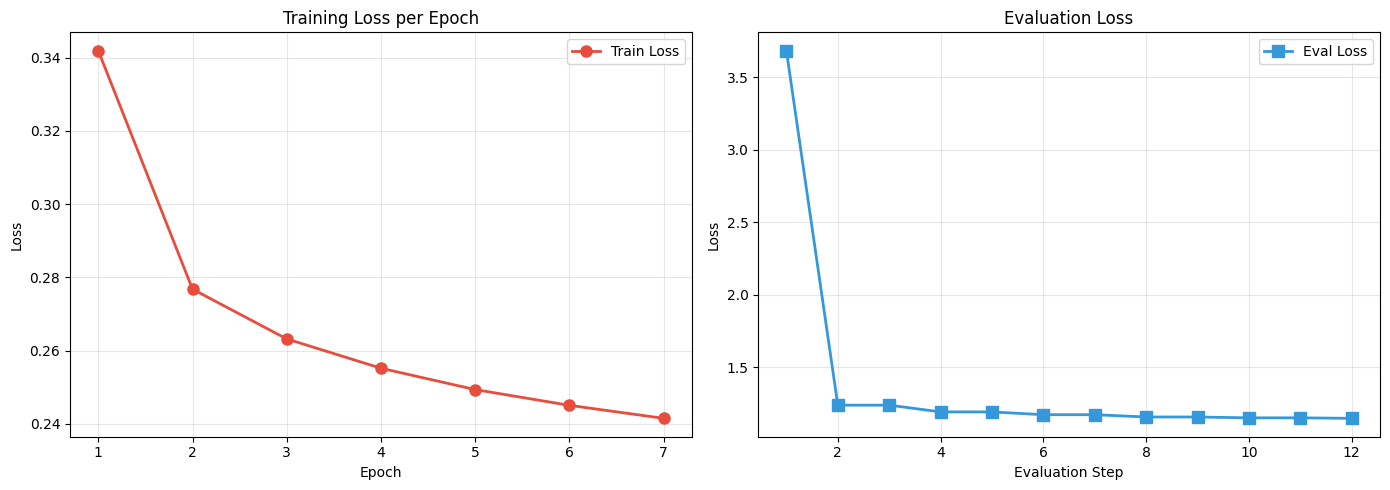


Loss reduction: 29.38%
Initial loss: 0.3419
Final loss: 0.2415


In [11]:
# Visualize training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training loss per epoch
epochs = range(1, len(train_history) + 1)
train_losses = [m['loss'] for m in train_history]

axes[0].plot(epochs, train_losses, marker='o', linewidth=2, markersize=8, 
             color='#e74c3c', label='Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss per Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Evaluation loss over time
if eval_history:
    eval_steps = range(1, len(eval_history) + 1)
    eval_losses = [m['eval_loss'] for m in eval_history]
    
    axes[1].plot(eval_steps, eval_losses, marker='s', linewidth=2, markersize=8,
                 color='#3498db', label='Eval Loss')
    axes[1].set_xlabel('Evaluation Step')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Evaluation Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print loss reduction
if len(train_losses) > 1:
    initial_loss = train_losses[0]
    final_loss = train_losses[-1]
    reduction = (initial_loss - final_loss) / initial_loss * 100
    print(f"\nLoss reduction: {reduction:.2f}%")
    print(f"Initial loss: {initial_loss:.4f}")
    print(f"Final loss: {final_loss:.4f}") 

## 10. Test Model Generation After Training

In [12]:
# Test generation on validation samples
print("=" * 70)
print("TESTING GENERATION AFTER TRAINING")
print("=" * 70)

student.model.eval()

# Get a batch from validation set
val_batch = next(iter(val_loader))
val_batch = {k: v.to(device) for k, v in val_batch.items()}

# Generate predictions
with torch.no_grad():
    generated_ids = student.generate(
        input_ids=val_batch['input_ids'][:3],  # First 3 samples
        attention_mask=val_batch['attention_mask'][:3],
        max_length=64,
        num_beams=4
    )

# Decode
predictions = student.decode_batch(generated_ids)
inputs = student.decode_batch(val_batch['input_ids'][:3])

labels = val_batch['labels'][:3].clone()
labels[labels == -100] = student.tokenizer.pad_token_id
ground_truths = student.decode_batch(labels)

# Display
for i in range(3):
    print(f"\n{'='*70}")
    print(f"SAMPLE {i+1}")
    print(f"{'='*70}")
    print(f"\nInput:\n{inputs[i]}")
    print(f"\nGround Truth:\n{ground_truths[i]}")
    print(f"\nPrediction:\n{predictions[i]}")

TESTING GENERATION AFTER TRAINING

SAMPLE 1

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: The sisters are hugging goodbye while holding to go packages after just eating lunch.

Ground Truth:
neutral explanation: The to go packages may not be from lunch.

Prediction:
neutral explanation: Just because two women are embracing while holding to go packages does not mean they are sisters hugging goodbye.

SAMPLE 2

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: Two woman are holding packages.

Ground Truth:
entailment explanation: Saying the two women are holding packages is a way to paraphrase that the packages they are holding are to go packages.

Prediction:
entailment explanation: Holding to go packages is a rephrasing of holding packages.

SAMPLE 3

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: The men are fighting outside a deli.

Ground Truth:
contradiction explanati

## 11. Test Checkpoint Saving and Loading

In [13]:
# Check saved checkpoints
print("=" * 70)
print("CHECKING SAVED CHECKPOINTS")
print("=" * 70)

output_dir = Path(training_config.output_dir)

if output_dir.exists():
    checkpoints = list(output_dir.iterdir())
    print(f"\nFound {len(checkpoints)} items in output directory:")
    for checkpoint in sorted(checkpoints):
        if checkpoint.is_dir():
            size = sum(f.stat().st_size for f in checkpoint.rglob('*') if f.is_file())
            print(f"- {checkpoint.name} ({size / 1e6:.2f} MB)")
        else:
            print(f"- {checkpoint.name}")
else:
    print("\nOutput directory not found!")

CHECKING SAVED CHECKPOINTS

Found 6 items in output directory:
- best_model (926.17 MB)
- checkpoint-3000 (926.17 MB)
- checkpoint-4000 (926.17 MB)
- checkpoint-5000 (926.17 MB)
- final_model (926.17 MB)
- training_config.json


## 12. Compare Before/After Training Performance

BEFORE/AFTER COMPARISON

Evaluation Loss:
  Initial: 3.6817
  Final: 1.1469
  Improvement: 2.5348 (68.85%)


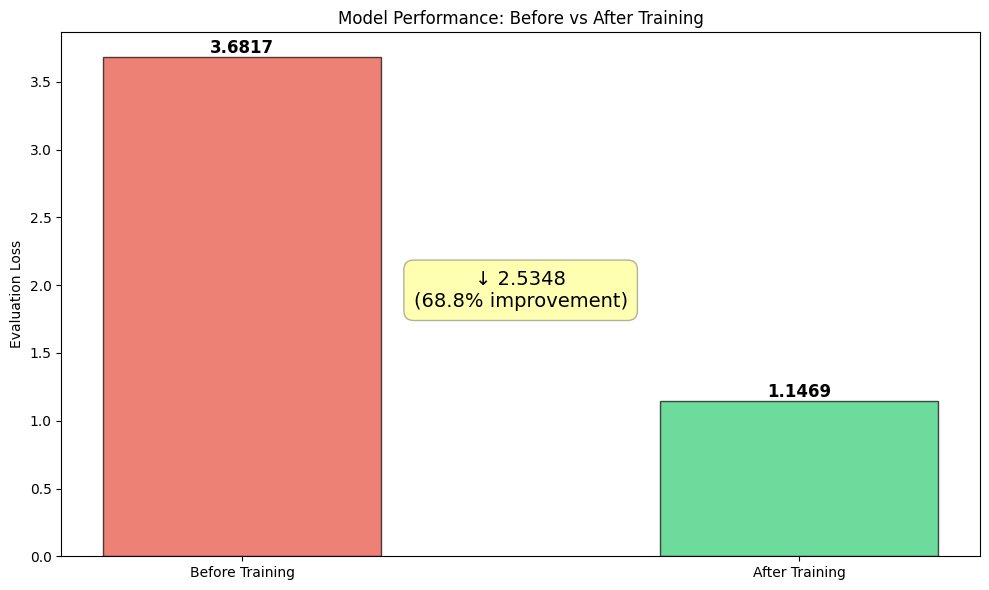

In [14]:
# Compare loss before and after training
print("=" * 70)
print("BEFORE/AFTER COMPARISON")
print("=" * 70)

if eval_history:
    initial_eval_loss = eval_history[0]['eval_loss']
    final_eval_loss = eval_history[-1]['eval_loss']
    
    print(f"\nEvaluation Loss:")
    print(f"  Initial: {initial_eval_loss:.4f}")
    print(f"  Final: {final_eval_loss:.4f}")
    print(f"  Improvement: {initial_eval_loss - final_eval_loss:.4f} ({(initial_eval_loss - final_eval_loss) / initial_eval_loss * 100:.2f}%)")
    
    # Visualize improvement
    fig, ax = plt.subplots(figsize=(10, 6))
    
    losses = [initial_eval_loss, final_eval_loss]
    labels = ['Before Training', 'After Training']
    colors = ['#e74c3c', '#2ecc71']
    
    bars = ax.bar(labels, losses, color=colors, alpha=0.7, edgecolor='black', width=0.5)
    ax.set_ylabel('Evaluation Loss')
    ax.set_title('Model Performance: Before vs After Training')
    
    # Add value labels
    for bar, loss in zip(bars, losses):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{loss:.4f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Add improvement annotation
    improvement = initial_eval_loss - final_eval_loss
    ax.annotate(
        f'↓ {improvement:.4f}\n({improvement/initial_eval_loss*100:.1f}% improvement)',
        xy=(0.5, max(losses) * 0.5),
        fontsize=14,
        ha='center',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3)
    )
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNo evaluation history available for comparison")

## 13. Memory and Speed Profiling

In [ ]:
# Profile inference speed (works with pre-trained model)
print("=" * 70)
print("PROFILING INFERENCE SPEED")
print("=" * 70)

student.model.eval()

if device == "cuda":
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    initial_memory = torch.cuda.memory_allocated() / 1e6

# Time inference step
times = []
for _ in range(5):
    batch = next(iter(val_loader))
    batch = {k: v.to(device) for k, v in batch.items()}
    
    start = time.time()
    
    with torch.no_grad():
        # Forward pass only (inference)
        outputs = student(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            labels=batch['labels']
        )
        
        # Also test generation
        generated_ids = student.generate(
            input_ids=batch['input_ids'][:4],
            attention_mask=batch['attention_mask'][:4],
            max_length=64,
            num_beams=4
        )
    
    if device == "cuda":
        torch.cuda.synchronize()
    
    times.append(time.time() - start)

avg_time = np.mean(times[1:])  # Skip first (warmup)
std_time = np.std(times[1:])

print(f"\nInference Performance (batch_size={len(batch['input_ids'])}):")
print(f"  Forward + Generate time: {avg_time:.3f}s ± {std_time:.3f}s")
print(f"  Throughput: {len(batch['input_ids']) / avg_time:.2f} samples/sec")

if device == "cuda":
    peak_memory = torch.cuda.max_memory_allocated() / 1e6
    print(f"\nMemory Usage:")
    print(f"  Initial: {initial_memory:.2f} MB")
    print(f"  Peak: {peak_memory:.2f} MB")
    print(f"  Overhead: {peak_memory - initial_memory:.2f} MB")
elif device == "mps":
    print(f"\n(MPS memory tracking not available)")

print(f"\nModel info:")
print(f"  Parameters: {student.count_parameters():,}")
print(f"  Memory footprint: {student.get_memory_footprint()['total_mb']:.2f} MB")

PROFILING TRAINING STEP

Training Step Performance:
  Average time: 0.177s ± 0.006s
  Throughput: 180.76 samples/sec

Memory Usage:
  Initial: 1257.95 MB
  Peak: 5712.52 MB
  Overhead: 4454.57 MB


## 14. Analyze Explanation Quality

Check the quality of generated explanations on validation samples.

In [ ]:
# Analyze explanation quality using quality_analysis module
print("=" * 70)
print("ANALYZING EXPLANATION QUALITY")
print("=" * 70)

# Get validation batch for analysis
val_batch_analysis = next(iter(val_loader))
val_batch_analysis = {k: v.to(device) for k, v in val_batch_analysis.items()}

student.model.eval()
with torch.no_grad():
    generated_ids = student.generate(
        input_ids=val_batch_analysis['input_ids'][:10],
        attention_mask=val_batch_analysis['attention_mask'][:10],
        max_length=64,
        num_beams=4
    )

predictions_analysis = student.decode_batch(generated_ids)
inputs_analysis = student.decode_batch(val_batch_analysis['input_ids'][:10])

labels_analysis = val_batch_analysis['labels'][:10].clone()
labels_analysis[labels_analysis == -100] = student.tokenizer.pad_token_id
ground_truths_analysis = student.decode_batch(labels_analysis)

# Analyze quality using imported function
quality_stats = analyze_batch_quality(
    predictions_analysis,
    ground_truths_analysis,
    inputs_analysis
)

# Print summary
print_quality_analysis(quality_stats)

# Show sample predictions
print(f"\n{'='*70}")
print("SAMPLE PREDICTIONS:")
print(f"{'='*70}")
for i in range(min(3, len(predictions_analysis))):
    print(f"\nSample {i+1}:")
    print(f"  Input: {inputs_analysis[i][:80]}...")
    print(f"  Ground Truth: {ground_truths_analysis[i]}")
    print(f"  Prediction: {predictions_analysis[i]}")

ANALYZING EXPLANATION QUALITY
EXPLANATION QUALITY ANALYSIS

📊 Tautology Detection:
  Tautologies: 3 (30.0%)
  Avg tautology similarity: 0.5544

🎯 Similarity to Ground Truth:
  Avg GT similarity: 0.3880

📏 Length Analysis:
  Avg prediction length: 18.7 words
  Avg GT length: 18.8 words
  Avg length ratio (pred/GT): 1.19

PROBLEMATIC EXAMPLES (Tautologies):

Example 1 (Sample 4):
  Input: nli premise: Two young children in blue jerseys, one with the number 9 and one w...
  Ground Truth: neutral explanation: Two kids in jerseys watching their hands are not necessaril...
  Prediction: neutral explanation: Just because two young children in blue jerseys, one with t...
  Tautology similarity: 0.7059

Example 2 (Sample 7):
  Input: nli premise: A man selling donuts to a customer during a world exhibition event ...
  Ground Truth: neutral explanation: Just because a customer buys donuts at a world exhibition e...
  Prediction: neutral explanation: A man selling donuts to a customer during a wo